In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
import os
import scipy
import time,datetime
import sys
from scipy.signal import savgol_filter

In [2]:
# 所需文件夹
path = os.getcwd()
if not os.path.exists(path+'\\image'):os.makedirs(path+'\\image')
if not os.path.exists(path+'\\results'):os.makedirs(path+'\\results')
# 读取数据
DL_data_final = pd.read_csv("data/DL_data_final.csv")[
    ['Family_NO', 'Person_NO', 'Travel_Purpose', 'MainTransport', 'Departure_Time', 'Arrival_Time', 'trip_time',
     'distance', 'SumCost', 'Departure_longitude', 'Departure_latitude', 'Destination_longitude', 'Destination_latitude',
     'Cars_Count', 'Sex', 'Age', 'Education','Career_Code', 'Is_Driver', 'Monday', 'Tuesday', 'Wednesday', 'Thursday',
     'Friday', 'Saturday', 'Sunday', 'Total_IN', 'Area', 'Nature', 'Members_Count']]
print(DL_data_final.index)

RangeIndex(start=0, stop=72851, step=1)


In [3]:
# 家庭编号，个人编号，出行目的，出行方式
DL_data_final.dropna(axis=0, how='any', subset=['Family_NO', 'Person_NO', 'Travel_Purpose', 'MainTransport'],inplace=True)

In [4]:
# DL_data_final.describe()

In [5]:
""" 补充缺失值 """
DL_data_final.fillna(method='ffill',axis=0,inplace=True)


""" 预测标签 """

# 出行目的

# purpose_columns = ['上班','上学','回家','购物','娱乐','旅游或出差','接送家人']
purpose_columns = ["Purpose_Work", "Purpose_School", "Purpose_Home", "Purpose_Shopping",
                   "Purpose_Entertainment",  "Purpose_Travel_or_Business_Trip", "Purpose_Take_Others"]
purpose_mapping = {26.0: 0, 27.0: 1, 28.0: 2, 29.0: 0, 30.0: 0, 31.0: 3, 32.0: 4, 33.0: 5,
                   34.0: 5, 35.0: 5, 36.0: 4, 90.0: 5, 203.0: 5, 214.0: 6}
DL_data_final['Travel_Purpose'] = (DL_data_final['Travel_Purpose']).map(purpose_mapping)

# 出行方式
# mode_columns = ['步行','公共汽车','地铁轻轨','出租车或网约车','私家车','定制公交或共享汽车']
mode_columns = ["Mode_Walk", "Mode_Bus", "Mode_Subway", "Mode_Taxi", "Mode_Car", "Mode_Custom_Bus_or_Shared_Car"]
mode_mapping = {38.0: 0, 39.0: 1, 40.0: 2, 41.0: 3, 42.0: 3, 43.0: 4, 44.0: 2,
                45.0: 5, 46.0: 1, 47.0: 2, 48.0: 5, 194.0: 5, 195.0: 5}
DL_data_final['MainTransport'] = (DL_data_final['MainTransport']).map(mode_mapping)


""" 布尔变量 """

# 驾驶证 (布尔变量) 【无调整】

# 私家车 (布尔变量)
DL_data_final['Cars_Count']= DL_data_final['Cars_Count'].astype("int")

# 性别 (布尔变量)
sex_mapping = {"男":1,"女":0}
DL_data_final['Sex'] = (DL_data_final['Sex']).map(sex_mapping)

# 房屋私有 (布尔变量)
nature_mapping = {76: 0, 77: 1, 78: 0, 79: 0}
DL_data_final['Nature'] = (DL_data_final['Nature']).map(nature_mapping)
DL_data_final.rename(columns = {'Nature': 'Is_Own_House'}, inplace=True)


""" 连续变量 """

# 出行费用（连续变量）
DL_data_final["SumCost"][DL_data_final.SumCost > 100]=100

# 出行时间（连续变量）
DL_data_final["trip_time"][DL_data_final.trip_time > 300] = 300
DL_data_final.drop(index=(DL_data_final.loc[DL_data_final['trip_time'] < 0]).index,inplace=True)

# 出行距离（连续变量）
DL_data_final.drop(index=(DL_data_final.loc[((DL_data_final['distance'] < 0.1) | (DL_data_final['distance'] > 300))]).index,inplace=True)


# 出发地 目的地经纬度约束（连续变量）
# 大连 北纬38°43′～40°12′，东经120°58′～123°31′

DL_data_final.drop(index=(DL_data_final.loc[((DL_data_final['Departure_latitude'] < 38.0)| (DL_data_final['Departure_latitude'] > 40.5)|
                                             (DL_data_final['Departure_longitude'] < 120.5)| (DL_data_final['Departure_longitude'] > 123.5))]
                         ).index,inplace=True) 
DL_data_final.drop(index=(DL_data_final.loc[((DL_data_final['Destination_latitude'] < 38.0)| (DL_data_final['Destination_latitude'] > 40.5)|
                                             (DL_data_final['Destination_longitude'] < 120.5)| (DL_data_final['Destination_longitude'] > 123.5))]
                         ).index,inplace=True) 

# 出发时间 到达时间（连续变量）

start_0_timestamp = pd.Timestamp("2021-09-27")
for i in (DL_data_final.index) :
    DL_data_final['Departure_Time'][i]= (pd.Timestamp(DL_data_final['Departure_Time'][i]) - start_0_timestamp) // pd.Timedelta('1s') % 86400 /3600
    DL_data_final['Arrival_Time'][i]= (pd.Timestamp(DL_data_final['Arrival_Time'][i]) - start_0_timestamp) // pd.Timedelta('1s') % 86400 /3600
     
""" 离散变量 """
# 家庭成员数量（离散变量）
member_columns = ['1','2','3','4','5','6 and more']
DL_data_final["Members_Count"][DL_data_final.Members_Count >= 6] = 6

# 年龄（离散变量）
age_columns = ['Age_0_to_10', 'Age_10_to_20', 'Age_20_to_30', 'Age_30_to_35', 'Age_35_to_40', 'Age_40_to_50', 'Age_50_to_60', 'Age_60_to_70', 'Age_70+']
age_mapping = {107: 5, 108: 5, 109: 15, 110: 15, 111: 25, 112: 25, 113: 35, 114: 38, 115: 45, 116: 55, 117: 65, 118: 75, 119: 75}
DL_data_final['Age'] = (DL_data_final['Age']).map(age_mapping)

# 文化水平（离散变量）
education_columns = ['Junior_secondary_and_below','High_school','undergraduate','Master_degree_or_above']
education_mapping = {2: 0, 3: 1, 4: 2, 5: 3, 80: 3}
DL_data_final['Education'] = (DL_data_final['Education']).map(education_mapping)

# 家庭年收入（离散变量）
total_income_columns = ['Total_Income_0_to_5w','Total_Income_5w_to_10w','Total_Income_10w_to_20w','Total_Income_20w_to_50w','Total_Income_50w+']
total_income_mapping = {70: 25, 71: 7.5, 72: 15, 73: 35, 74: 50}
DL_data_final['Total_IN'] = (DL_data_final['Total_IN']).map(total_income_mapping)

# 住房面积（离散变量）
house_area_columns = ['House_area_0_to_50','House_area_50_to_70','House_area_70_to_90','House_area_90_to_120','House_area_120_to_150']
house_area_mapping = {84: 50, 85: 70, 86: 90, 87: 120, 88: 150, 89: 150}
DL_data_final['Area'] = (DL_data_final['Area']).map(house_area_mapping)

# 家庭编号（one-hot）
# region_columns = ['中山区','西岗区','沙河口区','甘井子区','高新园区','旅顺口区','金普新区','普兰店区','瓦房店市','庄河市','长海县']
region_columns = ['Region_ZhongShan','Region_XiGang','Region_ShaHeKou','Region_GanJingZi','Region_GaoXinYuan','Region_LvShun',
                  'Region_JinPu','Region_PuLanDian','Region_WaFangDian','Region_ZhuangHe','Region_ChangHai']
family_region_mapping = {'02':0, '03':1, '04':2, '11':3, '99':4, '12':5, '13':6, '14':7, '81':8, '83':9, '24':10}
DL_data_final["Family_Region"] = DL_data_final["Family_NO"].str.split('-', expand=True)[0]
DL_data_final['Family_Region'] = (DL_data_final['Family_Region']).map(family_region_mapping)

# 职业（one-hot）
# career_columns = ['工人','农民','行政管理人员','幼儿园及小学生','中学生','无业','服务业人员','教育/研究人员',
#                   '医疗卫生人员','管理/技术人员','个体商户','军警人员','自由职业者','离退休人员','家庭主妇','其他']
career_columns = ['Career_Woker','Career_Farmer','Career_Administrative','Career_Primary','Career_Junior','Career_Unemployed','Career_Service','Career_Education',
                  'Career_Doctor','Career_Technical','Career_Individual','Career_Soldier','Career_Freelancer','Career_Retiree','Career_Housewife','Career_Others']
career_code_mapping = {8: 0, 9: 1, 10: 2, 11: 3, 12: 4, 13: 5, 14: 6, 15: 7, 16: 8, 17: 9, 18: 10, 19: 11, 20: 12, 21: 13, 22: 14, 23: 5, 24: 15}
DL_data_final['Career_Code'] = (DL_data_final['Career_Code']).map(career_code_mapping)

# 休息日（类似 one-hot）
dayoff_columns = ['Dayoff_Mon', 'Dayoff_Tue', 'Dayoff_Wed','Dayoff_Thur', 'Dayoff_Fri', 'Dayoff_Sat', 'Dayoff_Sun']
DL_data_final.rename(columns = {'Monday': 'Dayoff_Mon', 'Tuesday': 'Dayoff_Tue', 'Wednesday': 'Dayoff_Wed', 'Thursday': 'Dayoff_Thur',
                                'Friday': 'Dayoff_Fri', 'Saturday': 'Dayoff_Sat', 'Sunday': 'Dayoff_Sun'}, inplace=True)

D:\Program_Files\miniconda\envs\TF2.1\lib\site-packages\ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
D:\Program_Files\miniconda\envs\TF2.1\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
D:\Program_Files\miniconda\envs\TF2.1\lib\site-packages\ipykernel_launcher.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
D:\Program_Files\miniconda\envs\TF2.1\lib\site-packages\ipyke

In [6]:
# 数据分布情况
DL_data_final.describe().to_csv("describe00.csv")
DL_data_final.describe()

,Travel_Purpose,MainTransport,trip_time,distance,SumCost,Departure_longitude,Departure_latitude,Destination_longitude,Destination_latitude,Cars_Count,...,Dayoff_Wed,Dayoff_Thur,Dayoff_Fri,Dayoff_Sat,Dayoff_Sun,Total_IN,Area,Is_Own_House,Members_Count,Family_Region
count,71331.000000,71331.000000,71331.000000,71331.000000,71331.000000,71331.000000,71331.000000,71331.000000,71331.000000,71331.000000,...,71331.000000,71331.000000,71331.000000,71331.000000,71331.000000,71331.000000,71331.000000,71331.000000,71331.000000,71331.000000
mean,1.782198,2.058516,30.044539,19.437807,2.248749,121.730740,39.060440,121.731656,39.061077,0.696107,...,0.140234,0.137458,0.135411,0.677532,0.743155,15.850857,92.002916,0.914259,2.696163,4.201329
std,1.604547,1.790827,25.186127,35.585254,6.161719,0.344453,0.245024,0.345138,0.245687,0.459940,...,0.347232,0.344332,0.342164,0.467424,0.436896,9.436216,25.421318,0.279983,0.860735,2.431336
min,0.000000,0.000000,0.000000,0.100255,0.000000,121.125817,38.734641,121.125817,38.730784,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,7.500000,50.000000,0.000000,1.000000,0.000000
25%,0.000000,0.000000,15.000000,1.510050,0.000000,121.558661,38.912911,121.558909,38.912940,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,7.500000,70.000000,1.000000,2.000000,3.000000
50%,2.000000,2.000000,25.000000,4.667080,0.000000,121.622608,38.976093,121.623521,38.976155,1.000000,...,0.000000,0.000000,0.000000,1.000000,1.000000,15.000000,90.000000,1.000000,3.000000,3.000000
75%,2.000000,4.000000,40.000000,16.250500,1.000000,121.779962,39.069874,121.781330,39.069999,1.000000,...,0.000000,0.000000,0.000000,1.000000,1.000000,25.000000,120.000000,1.000000,3.000000,6.000000
max,6.000000,5.000000,300.000000,264.964996,100.000000,123.451204,40.150461,123.451204,40.150461,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,50.000000,150.000000,1.000000,6.000000,10.000000


In [20]:
# DL_data_final['Departure_Time'].describe()
print(np.percentile(DL_data_final['Departure_Time'], 0))
print(np.percentile(DL_data_final['Departure_Time'], 25))
print(np.percentile(DL_data_final['Departure_Time'], 50))
print(np.percentile(DL_data_final['Departure_Time'], 75))
print(np.percentile(DL_data_final['Departure_Time'], 100))
print(np.mean(DL_data_final['Departure_Time']))
print(np.std(DL_data_final['Departure_Time']))
print("--------")
print(np.percentile(DL_data_final['Arrival_Time'], 0))
print(np.percentile(DL_data_final['Arrival_Time'], 25))
print(np.percentile(DL_data_final['Arrival_Time'], 50))
print(np.percentile(DL_data_final['Arrival_Time'], 75))
print(np.percentile(DL_data_final['Arrival_Time'], 100))
print(np.mean(DL_data_final['Arrival_Time']))
print(np.std(DL_data_final['Arrival_Time']))

0.08333333333333333
7.5
9.666666666666666
17.0
23.75
11.94744127144358
4.852062165098739
--------
0.16666666666666666
8.0
10.25
17.5
23.983333333333334
12.45972858925282
4.879789861359658


### 绘图

In [7]:
# 0-1 变量 
bool_variables_columns = ['Cars_Count', 'Sex', 'Is_Driver', 'Is_Own_House']
for column in bool_variables_columns:
    print(DL_data_final[column].value_counts())
#     plt.bar(x = DL_data_final[column].value_counts().index, height = DL_data_final[column].value_counts())
#     plt.xticks([0,1], [0,1]) 
#     plt.show()

1    49654
0    21677
Name: Cars_Count, dtype: int64
1    36515
0    34816
Name: Sex, dtype: int64
0    37413
1    33918
Name: Is_Driver, dtype: int64
1    65215
0     6116
Name: Is_Own_House, dtype: int64


45    17498
38    11636
35     9674
55     7394
65     6147
25     6021
15     6016
5      4931
75     2014
Name: Age, dtype: int64


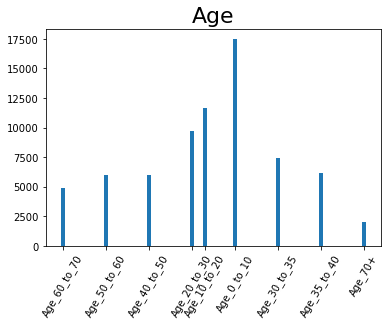

2    32279
0    19063
1    17651
3     2338
Name: Education, dtype: int64


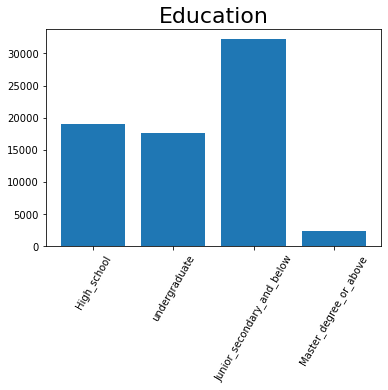

7.5     28559
15.0    23754
25.0    11962
35.0     6113
50.0      943
Name: Total_IN, dtype: int64


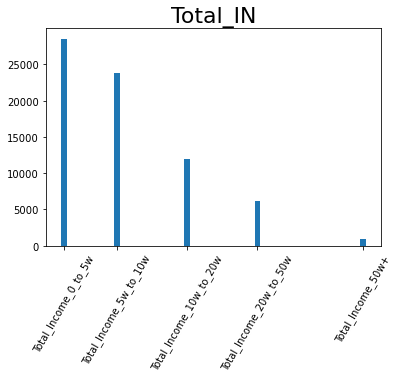

90     26564
70     19778
120    15367
50      4999
150     4623
Name: Area, dtype: int64


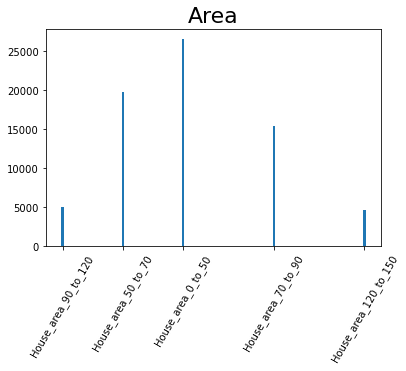

3    34498
2    19618
4     9799
1     6689
5      657
6       70
Name: Members_Count, dtype: int64


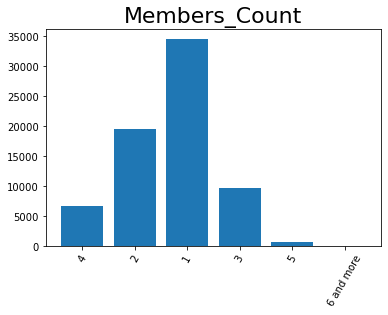

In [8]:
# 离散变量
discrete_variables_columns = ['Age', 'Education', 'Total_IN', 'Area', 'Members_Count']
variables_column_names = [age_columns,education_columns,total_income_columns,house_area_columns,member_columns]

for column,column_name in zip(discrete_variables_columns,variables_column_names):
    print(DL_data_final[column].value_counts())

    fig, ax = plt.subplots()
    ax.bar(DL_data_final[column].value_counts().index,DL_data_final[column].value_counts())
    plt.title(column, fontsize=22)
    plt.xticks(DL_data_final[column].value_counts().index,column_name,rotation=60)  
    plt.show()
    

0.00     48055
1.00      7634
2.00      3143
10.00     2240
5.00      1210
         ...  
13.43        1
34.44        1
9.07         1
66.00        1
27.60        1
Name: SumCost, Length: 190, dtype: int64


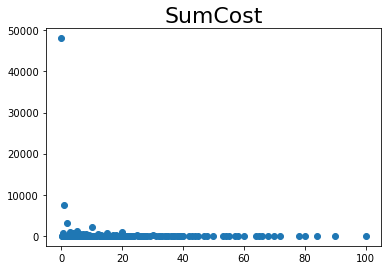

17.000000    6463
7.500000     4838
7.000000     4113
8.000000     3481
17.500000    3150
             ... 
11.816667       1
21.283333       1
21.883333       1
12.633333       1
21.516667       1
Name: Departure_Time, Length: 874, dtype: int64


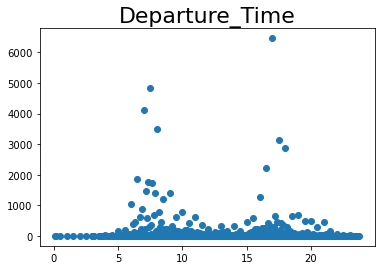

8.000000     3030
8.500000     2582
7.500000     2262
17.500000    2048
7.833333     2025
             ... 
12.133333       1
12.533333       1
21.483333       1
19.300000       1
22.016667       1
Name: Arrival_Time, Length: 1017, dtype: int64


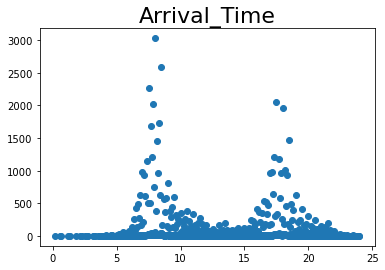

30     12159
20     10653
10     10548
15      7793
40      4506
       ...  
263        1
254        1
147        1
215        1
187        1
Name: trip_time, Length: 169, dtype: int64


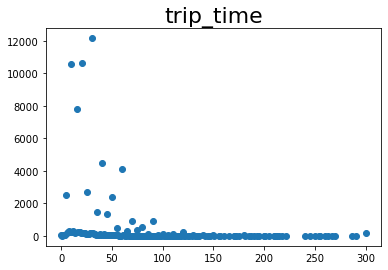

0.143624     61
0.712861     55
0.813344     46
0.163143     44
0.880343     38
             ..
2.438000      1
6.748930      1
6.735940      1
8.819040      1
10.691900     1
Name: distance, Length: 42353, dtype: int64


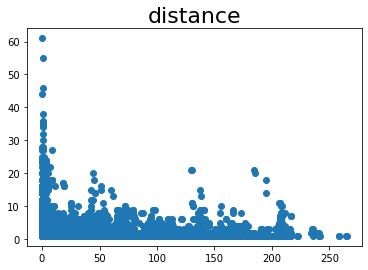

121.532724    278
121.614682    264
121.778779    193
122.967328    186
121.191362    183
             ... 
121.766645      1
121.657676      1
121.659210      1
121.638407      1
121.513352      1
Name: Departure_longitude, Length: 11512, dtype: int64


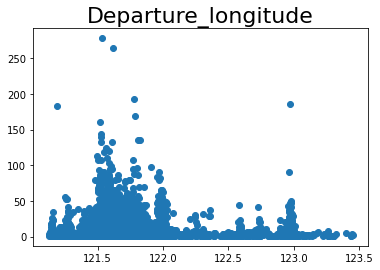

38.862515    284
38.914003    264
39.049712    193
39.680811    186
38.794508    183
            ... 
38.950776      1
38.959627      1
38.888027      1
38.977397      1
38.885094      1
Name: Departure_latitude, Length: 11452, dtype: int64


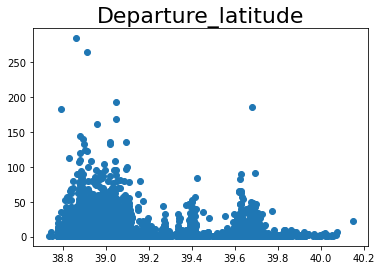

121.532724    283
121.614682    262
121.778779    195
121.191362    187
122.967328    183
             ... 
121.599107      1
121.536502      1
121.830610      1
121.554569      1
121.513352      1
Name: Destination_longitude, Length: 11591, dtype: int64


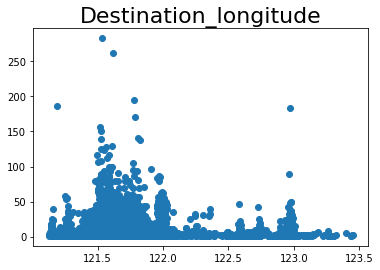

38.862515    289
38.914003    262
39.049712    195
38.794508    187
39.680811    183
            ... 
38.973361      1
39.070253      1
39.125034      1
39.035693      1
38.885094      1
Name: Destination_latitude, Length: 11531, dtype: int64


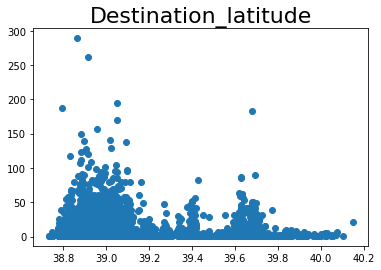

In [9]:
# 连续变量
continuous_variables_columns = ['SumCost','Departure_Time','Arrival_Time', 'trip_time', 'distance', 'Departure_longitude',
                                'Departure_latitude', 'Destination_longitude', 'Destination_latitude'] 

for column in continuous_variables_columns:
    print(DL_data_final[column].value_counts())
     # 绘散点图
    fig, ax = plt.subplots()
    ax.scatter(DL_data_final[column].value_counts().index,DL_data_final[column].value_counts())
    plt.title(column, fontsize=22)
    plt.show()

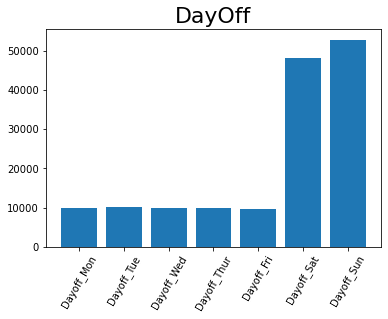

In [10]:
dayoff_columns = ['Dayoff_Mon', 'Dayoff_Tue', 'Dayoff_Wed','Dayoff_Thur', 'Dayoff_Fri', 'Dayoff_Sat', 'Dayoff_Sun']
dayoff_y = []
for column in dayoff_columns:
    
    dayoff_y.append(DL_data_final[column].sum())

fig, ax = plt.subplots()
ax.bar([0,1,2,3,4,5,6],dayoff_y)
plt.title("DayOff", fontsize=22)
plt.xticks([0,1,2,3,4,5,6],dayoff_columns,rotation=60)  
plt.show()

3     20973
6     15410
2      7035
4      6948
0      4994
8      4237
9      3770
1      3164
7      2267
5      1949
10      584
Name: Family_Region, dtype: int64


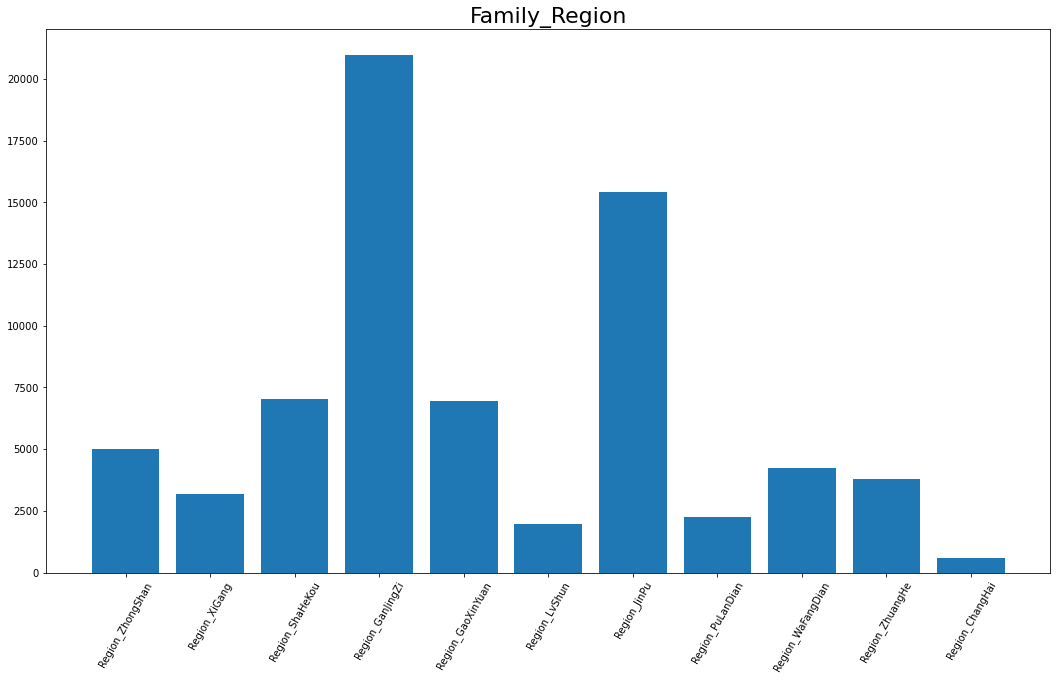

In [11]:
# region_columns = ['中山区','西岗区','沙河口区','甘井子区','高新园区','旅顺口区','金普新区','普兰店区','瓦房店市','庄河市','长海县']
region_columns = ['Region_ZhongShan','Region_XiGang','Region_ShaHeKou','Region_GanJingZi','Region_GaoXinYuan','Region_LvShun',
                  'Region_JinPu','Region_PuLanDian','Region_WaFangDian','Region_ZhuangHe','Region_ChangHai']

print(DL_data_final["Family_Region"].value_counts())
region = pd.get_dummies(DL_data_final['Family_Region']).astype('int') 
region.columns=region_columns
region_y = []
for column in region_columns:
    DL_data_final[column] = region[column]
    region_y.append(DL_data_final[column].sum())

# 绘散点图
fig, ax = plt.subplots(figsize=(18, 10))
ax.bar(range(11),region_y)
plt.title("Family_Region", fontsize=22)
plt.xticks(range(11),region_columns,rotation=60)  
plt.show()

13    9411
15    7649
0     6967
9     6791
3     6264
6     6040
10    5285
2     4623
4     4358
12    4289
7     2566
14    2521
5     1538
8     1537
11     817
1      675
Name: Career_Code, dtype: int64


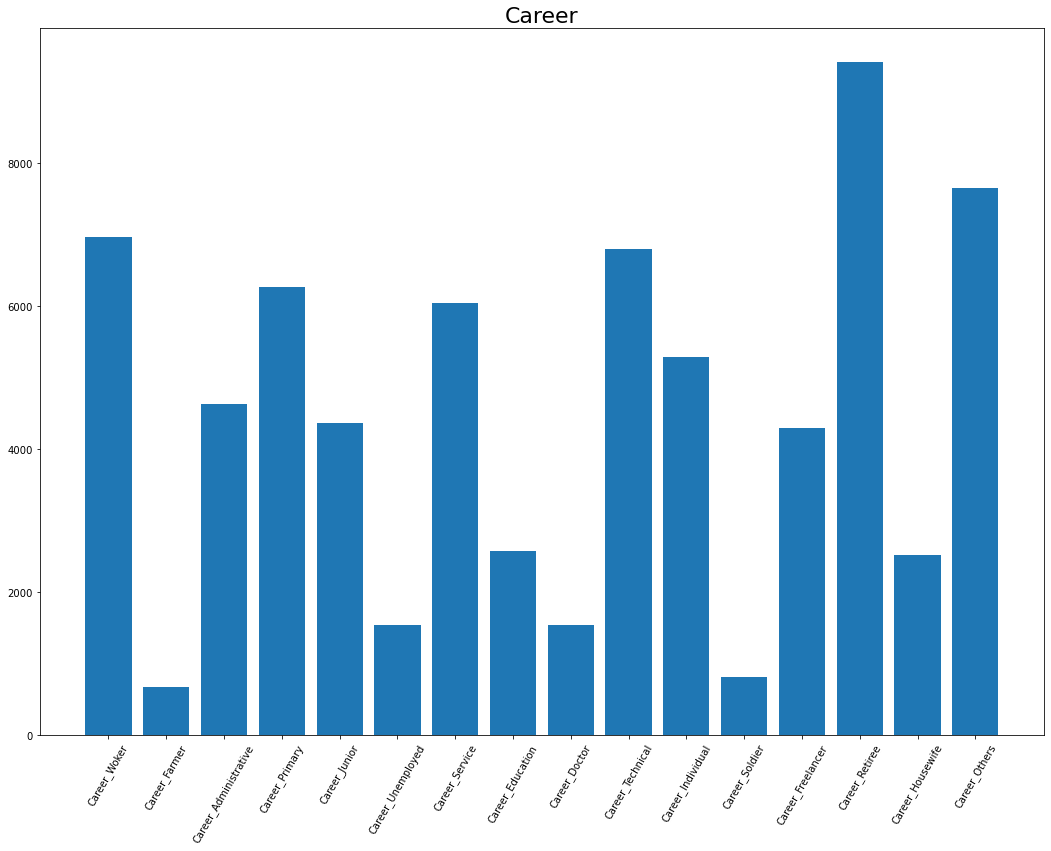

In [12]:
# career_columns = ['工人','农民','行政管理人员','幼儿园及小学生','中学生','无业','服务业人员','教育/研究人员',
#                   '医疗卫生人员','管理/技术人员','个体商户','军警人员','自由职业者','离退休人员','家庭主妇','其他']
career_columns = ['Career_Woker','Career_Farmer','Career_Administrative','Career_Primary','Career_Junior','Career_Unemployed','Career_Service','Career_Education',
                  'Career_Doctor','Career_Technical','Career_Individual','Career_Soldier','Career_Freelancer','Career_Retiree','Career_Housewife','Career_Others']

print(DL_data_final["Career_Code"].value_counts())
career = pd.get_dummies(DL_data_final['Career_Code']).astype('int') 
career.columns=career_columns

career_y = []
for column in career_columns:
    DL_data_final[column] = career[column]
    career_y.append(DL_data_final[column].sum())

# 绘散点图
fig, ax = plt.subplots(figsize=(18, 13))
ax.bar(range(16),career_y)
plt.title("Career", fontsize=22)
plt.xticks(range(16),career_columns,rotation=60)  
plt.show()

2    32827
0    20556
1     5486
6     4798
3     4592
4     1938
5     1134
Name: Travel_Purpose, dtype: int64


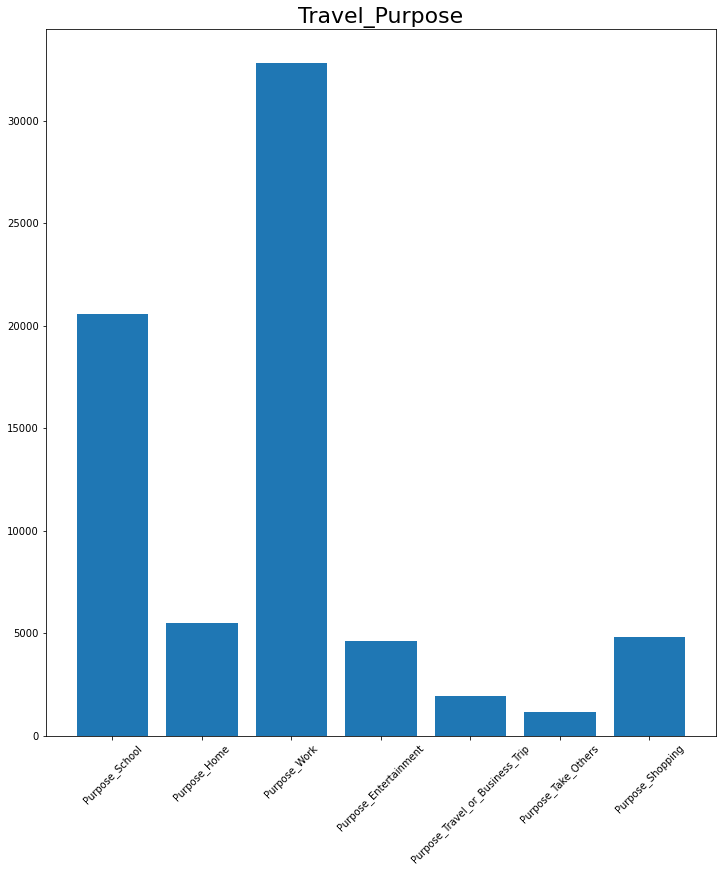

4    28582
0    22943
1    12196
2     4390
3     2284
5      936
Name: MainTransport, dtype: int64


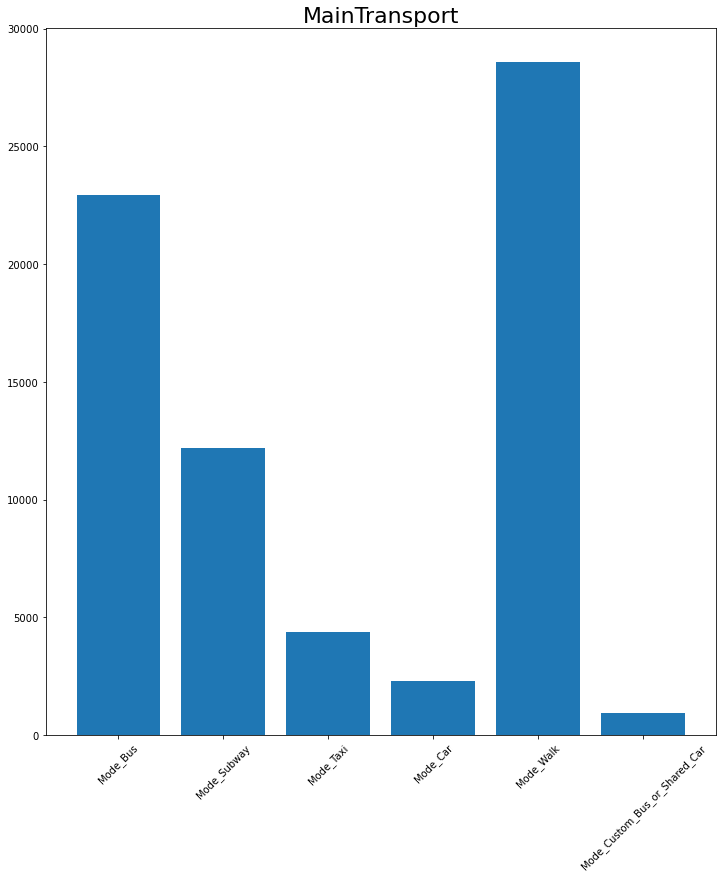

In [13]:
# 预测标签
prediction_items = ['Travel_Purpose', 'MainTransport']
column_names = [purpose_columns,mode_columns]


for prediction,column_name in zip(prediction_items,column_names):
    print(DL_data_final[prediction].value_counts())
    
    
    fig, ax = plt.subplots(figsize=(12, 13))
    fig.figsize=(12, 13)
    ax.bar(DL_data_final[prediction].value_counts().index,DL_data_final[prediction].value_counts())
    plt.title(prediction, fontsize=22)
    plt.xticks(DL_data_final[prediction].value_counts().index,column_name,rotation=45)
    plt.show()

In [14]:
# DL_data_final.drop(columns=['level_0','index'],inplace = True)
DL_data_final.reset_index(inplace=True)

print(DL_data_final.columns)
# DL_data_final.to_csv("data/DL_data_final_non_standard.csv")

Index(['index', 'Family_NO', 'Person_NO', 'Travel_Purpose', 'MainTransport',
       'Departure_Time', 'Arrival_Time', 'trip_time', 'distance', 'SumCost',
       'Departure_longitude', 'Departure_latitude', 'Destination_longitude',
       'Destination_latitude', 'Cars_Count', 'Sex', 'Age', 'Education',
       'Career_Code', 'Is_Driver', 'Dayoff_Mon', 'Dayoff_Tue', 'Dayoff_Wed',
       'Dayoff_Thur', 'Dayoff_Fri', 'Dayoff_Sat', 'Dayoff_Sun', 'Total_IN',
       'Area', 'Is_Own_House', 'Members_Count', 'Family_Region',
       'Region_ZhongShan', 'Region_XiGang', 'Region_ShaHeKou',
       'Region_GanJingZi', 'Region_GaoXinYuan', 'Region_LvShun',
       'Region_JinPu', 'Region_PuLanDian', 'Region_WaFangDian',
       'Region_ZhuangHe', 'Region_ChangHai', 'Career_Woker', 'Career_Farmer',
       'Career_Administrative', 'Career_Primary', 'Career_Junior',
       'Career_Unemployed', 'Career_Service', 'Career_Education',
       'Career_Doctor', 'Career_Technical', 'Career_Individual',
       'Car